In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import shuffle
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr

2024-01-03 05:52:13.961517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
enformer_model = custom_model.Enformer(track_index=5111, bin_index=[447, 448])

2024-01-03 05:52:16.091168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 05:52:16.439383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79005 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [3]:
model = custom_model.Borzoi('../data/borzoi/*/*', track_index=51, aggregate=True)


Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
delta_seq_length = (model.seq_length - enformer_model.seq_length) // 2

In [5]:
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')
seq = seq_parser.extract_seq_centered('chr1', 100000000, '+', model.seq_length)

In [6]:
seq_enf = seq_parser.extract_seq_centered('chr1', 100000000, '+', enformer_model.seq_length)

In [8]:
np.array_equal(seq_enf[804:5804], seq[delta_seq_length+804:delta_seq_length+5804])

True

In [9]:
enformer_model.seq_length

196608

In [10]:
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, 5000)


In [6]:
tile_coords = pd.read_csv(f'../results/summary_csvs/enformer//sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values

In [11]:
np.array_equal(cre_tiles_starts, np.array(cre_tiles)[:, 0])

True

In [11]:
len(cre_tiles)

102

In [12]:
cre_df=pd.read_csv( f'../results/summary_csvs/enformer/sufficient_CREs.csv')


In [15]:
cre_df.groupby(['context', 'tile class']).count()

,,Unnamed: 0,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,cell_line,Normalized CRE effect
context,tile class,,,,,,,,,,,
enhancing,Enhancer,150,150,150,150,150,150,150,150,150,150,150
silencing,Silencer,376,376,376,376,376,376,376,376,376,376,376


In [28]:
res_path = '../results/higher_order_test_min/enformer/K562/ABCA5_chr17_69327133_-.pickle'

In [29]:
res = utils.read_pickle(res_path)

In [51]:
perturb_window = 5000

In [40]:
chrom, start, strand = res_path.split('/')[-1].split('.')[0].split('_')[1:]

In [41]:
data_dir = '../data/'
fasta_path = f'{data_dir}/GRCh38.primary_assembly.genome.fa'

In [42]:
seq_parser = utils.SequenceParser(fasta_path)


In [45]:
x = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length, onehot=True)


In [52]:
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)


In [58]:
only_tss_seqs = shuffle.dinuc_shuffle(x, 10)
only_tss_seqs[:, tss_tile[0]:tss_tile[1],:] = x[tss_tile[0]:tss_tile[1],:].copy()

In [59]:
only_tss_preds = model.predict(only_tss_seqs)

In [60]:
only_tss_preds.mean()

0.55303144

In [62]:
current_seq = only_tss_seqs.copy()
predictions = []
for i in tqdm(res.keys()):
    tile_start, tile_end = res[i]['selected_tile']
    current_seq[:, tile_start: tile_end,:] = x[tile_start: tile_end,:].copy()
    predictions.append(model.predict(current_seq).mean())

    

100%|██████████████████████████████████████████████████████████████████| 25/25 [01:10<00:00,  2.80s/it]


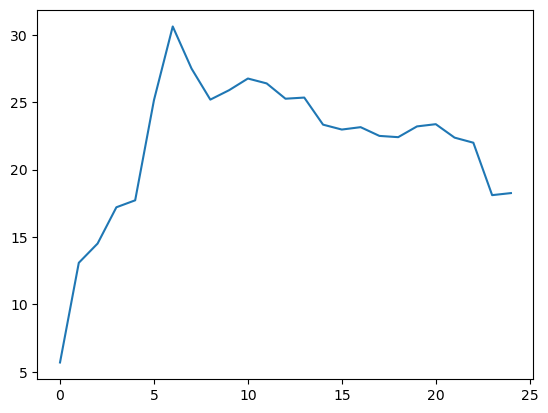

In [63]:
plt.plot(predictions)

In [34]:
wt = res[0]['initial_pred']
trace = [res[i]['initial_pred']/wt for i in res.keys()]

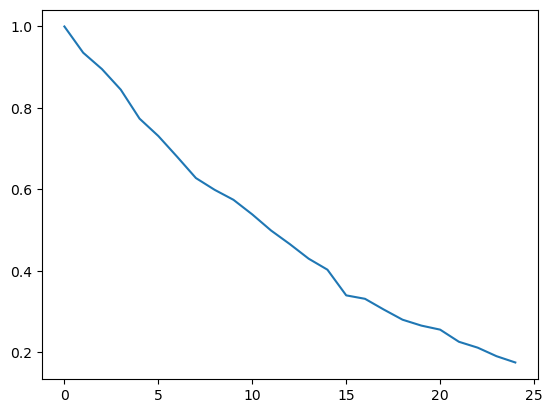

In [35]:
plt.plot(trace)